<a href="https://colab.research.google.com/github/Padmapalita/Portfolio_Deep_Learning_CNN/blob/main/CIFAR100_Lotus_model_(unmodified)_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lotus Model applied to the CIFAR-100 image set

This notebook takes the Lotus model I developed for the CIFAR-10 images set according to a tailored specification from a deep learning researcher as part of my Masters Data Science and Artifical Intelligence. 

This current notebook applies that model to a different but similar problem the CIFAR-100 image set.

**Note: This notebook needs at least 40gb GPU and will take approximately 11 hours to train the model**

Please import the my_utils.py into the environment in order for the notebook to run. 

In [ ]:
#Import libraries
import my_utils as mu
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils import data

In [ ]:
# Set up the GPU from pytorch cuda and confirm the device available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu

Using device: cuda
NVIDIA A100-SXM4-40GB


## Section 1: Read the dataset and create dataloaders

During development I have experimented with a number of transformations and normalisation on the training set to prevent early overfitting. 

The only code I have taken from other sources in this project (with the exception of my_utilities.py and inspiration from the VGG model) is the normalisation values taken from the D2l.ai chapter on the CIFAR set which is used in the code below. 



In [ ]:
# create the dataloaders
def get_dataloader_workers(): 
    """Use 4 processes to read the data."""
    return 4


def load_data_cifar_10(batch_size, resize=None):  
    """Download the CIFAR_10 dataset and then load it into memory.
    normalisation values taken from https://d2l.ai/chapter_computer-vision/kaggle-cifar10.html
    """
    # transfomrations used on the training set
    train_trans = [transforms.RandomResizedCrop(size=56, scale=(0.60, 1.0)),
                   transforms.RandomAffine(5), 
                   transforms.RandomHorizontalFlip(0.5), 
                   transforms.RandomVerticalFlip(0.15),
                   transforms.RandomRotation(50), 
                   transforms.RandomPerspective(0.15) ,
                   transforms.RandomGrayscale(p=0.05),
                   transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.15,), 
                   transforms.ToTensor(),
                   transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)) ]
    # normalisation used for the test set
    test_trans = [transforms.ToTensor(),
                  transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)) ]

    if resize:
        train_trans.insert(0, transforms.Resize(resize))
        test_trans.insert(0, transforms.Resize(resize))

    train_trans = transforms.Compose(train_trans)
    test_trans = transforms.Compose(test_trans)
    torchvision.datasets.CIFAR10
    cifar_train = torchvision.datasets.CIFAR100(root="../data", train=True, transform=train_trans, download=True)
    cifar_test = torchvision.datasets.CIFAR100(root="../data", train=False, transform=test_trans, download=True)
    return (data.DataLoader(cifar_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(cifar_test, batch_size, shuffle=False,num_workers=get_dataloader_workers()))

In [ ]:
# Load the train and test batches
batch_size = 320
resize = 56

train_iter, test_iter = load_data_cifar_10(batch_size, resize=resize)

100%|██████████| 169001437/169001437 [00:02<00:00, 80507306.17it/s]


Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified


## Section 2: Create the model

## The Lotus model
The model consists of block repeating 4 times and a multilayer perception with 6 layers (4 hidden)

The number of channels increases block by block
- block 1: 3 channels in 96 channels out
- block 2: 96 channels in 256 channels out
- block 3: 256 channels in 512 channels out
- black 4: 512 channels in 1024 channels out

The models takes a resized image 52x52 
- Block 1: reduces the feature map to 28x28
- Block 2: reduces the feature map to 14x14
- Block 3: reduces the feature map to 7x7
- Block 4: reduces the feature map to 3x3

The repeating block uses the following operations.
The batch X is processed by two seperate processes:

**Process 1.** X is passed through AdaptiveAvgPool to produce 1 value per channel. This is then passed through a nn.linear model which outputs the same number of features out needed by process 2 nn.ReLu is used for a nonlinear transformation. The output of this process is called vector A.

**Process 2.** X is passed into K number of convolutional layers. Each layer is seperate and passes X through a 3x3 conv kernel, a ReLU, a second 3x3 conv kernel, a second relu, a third 3x3 conv kernel, a third relu. 
Process 2 stacks K number of outputs together

**Vector A and Stacked K Linear combination:**
Stacked K is then flattened (start_dim=2) and torch.matmul is used to combined i-th element of vector A with the i-th convolutional output of stack K.  This is then reshaped back into a 4 dimensional Tensor (batchsize, output_channels, H, W)

**Norm and maxpool:** Before the end of each block the  output (linear combination of Vactor A and Stack K) is processed by nn.batchNorm2D and NN.MaxPool2D




In [ ]:
## This is the basic block
class Lotus_Block(nn.Module):
    def __init__(self, K_conv_layers, channels_in, output_channels, batch_size):
        super(Lotus_Block, self).__init__()
        self.batch_size = batch_size
        self.K_conv_layers = K_conv_layers
        self.channels_in = channels_in
        self.output_channels = output_channels

        # create the models elements
        self.Spatial = nn.AdaptiveAvgPool2d(output_size=1)
        self.Linear = nn.Linear(self.channels_in,self.K_conv_layers)
        self.NLactivation = nn.ReLU()
        self.flat2ndD = nn.Flatten(start_dim=2)

        # create elements for k number of convultional layers
        for i in range(self.K_conv_layers):
            self.add_module('conv{0}'.format(i), nn.Conv2d(self.channels_in, self.output_channels, kernel_size=3, padding=1, stride=1))
            self.input_channels = self.output_channels
            self.add_module('relu{0}'.format(i), nn.ReLU())
            self.add_module('conv2{0}'.format(i), nn.Conv2d(self.output_channels, self.output_channels, kernel_size=3, padding=1, stride=1))
            self.add_module('relu2{0}'.format(i), nn.ReLU())
            self.add_module('conv3{0}'.format(i), nn.Conv2d(self.output_channels, self.output_channels, kernel_size=3, padding=1, stride=1))
            self.add_module('relu3{0}'.format(i), nn.ReLU())

        self.batch = nn.BatchNorm2d(self.output_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self, x):
        # manage the dimensions for reshapes and variable batchsize 
        self.input_dimensions = x.size()[3]
        self.batch_size = x.size()[0]
        #self.Spatial = nn.AdaptiveAvgPool2d(output_size=1)

        # PROCESS 1: create vector A
        A = self.Spatial(x)
        A = torch.reshape(A, (self.batch_size,self.channels_in))
        A = self.Linear(A)
        A = torch.reshape(A,(self.batch_size,1, self.K_conv_layers))

        # PROCESS 2: K number of stacked convolutional outputs
        to_be_stacked = []
        for i in range(self.K_conv_layers):

            out = self._modules['conv{0}'.format(i)](x)
            out = self._modules['relu{0}'.format(i)](out)
            out = self._modules['conv2{0}'.format(i)](out)
            out = self._modules['relu2{0}'.format(i)](out)
            out = self._modules['conv3{0}'.format(i)](out)
            out = self._modules['relu3{0}'.format(i)](out)
            to_be_stacked.append(out)

        # stack and flatten K number of convolutional outputs
        stack_K = torch.stack(to_be_stacked, dim=1)
        stack_K = self.flat2ndD(stack_K)
        # END of process 2. 

        # linear combination of the vector A and Stacked K number of 
        output = torch.matmul(A,stack_K)
        # reshape the combination for final steps in block
        output = torch.reshape(output,(self.batch_size,self.output_channels,self.input_dimensions,self.input_dimensions))
        
        # batch normalisation and max pooling
        output = self.batch(output)
        output = self.max_pool(output)
        return output  

The Model Class takes a list of tuples. 
Each tuple represents the K number of convolutional outputs to be stacked, and the number of output channels/planes which the block will result in. 

Batch size is also passed into the model. 

After the final block has been run, **the model uses a 6 layer MLP for classification of the images:**

- The classifer starts with an AdaptiveAvgPool2d which summarises the final feature map into a single value for each channel (inline with the specification).

- Each layer in the classifer has 4096 perceptrons with the exception of the input (n=1024) and the output (n=100) layers.

- Each layer has ReLU transformation and dropout layer.

- SoftMax Regression is achieve by the use of CrossEntropyLoss



In [ ]:
# the model which combines the blocks and classifies the dataset.

class Lotus_Model(nn.Module):

    def __init__(self, structure, batch_size):
        super(Lotus_Model, self).__init__()
        
        # 3 channels for an RGB image set
        in_channels = 3  
        #structure is the list of tuples (K_conv_layers, out_channels)
        self.structure = structure

        # run a number of blocks with the given structure
        for i, (K_conv_layers ,out_channels) in enumerate(self.structure):
          self.add_module('Lotus_Block{0}'.format(i), Lotus_Block(K_conv_layers, in_channels, out_channels, batch_size))
          in_channels = out_channels
        
        # The Classifer
        self.last = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=1), nn.Flatten(), 
                                nn.Linear(out_channels, 4096), nn.ReLU(), nn.Dropout(0.5),
                                nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
                                nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5), 
                                nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5), 
                                nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5), 
                                nn.Linear(4096, 100))
      

    def forward(self, x):
        out = x

        # foward through the blocks
        for i in range(len(self.structure)):
            out = self._modules['Lotus_Block{0}'.format(i)](out)
        # forward through the classifier
        out = self.last(out)
        return out


Create the model and initialise it to the GPU. 

I have used Xavier_uniform to intialise the models weights. 

In [ ]:
structure = ((5, 96), (5, 256), (5, 512),  (5, 1024))
batch_size = 320

net = Lotus_Model(structure, batch_size)


In [ ]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d : 
        torch.nn.init.xavier_uniform_(m.weight)   

net.to(device)
net.train()
net.apply(init_weights)

Lotus_Model(
  (Lotus_Block0): Lotus_Block(
    (Spatial): AdaptiveAvgPool2d(output_size=1)
    (Linear): Linear(in_features=3, out_features=5, bias=True)
    (NLactivation): ReLU()
    (flat2ndD): Flatten(start_dim=2, end_dim=-1)
    (conv0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv20): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu20): ReLU()
    (conv30): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu30): ReLU()
    (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv21): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu21): ReLU()
    (conv31): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu31): ReLU()
    (conv2): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (conv22): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding

Demonstrate that the model will produce 100 class predictions

In [ ]:
a = torch.rand(320, 3, 32, 32)
a = a.to(device)
print(a.size())
out = net(a)
print(out.size())


torch.Size([320, 3, 32, 32])
torch.Size([320, 100])


## Section 3: Create the loss and the optimizer

I have used Cross Entropy Loss to as this will achieve the SoftMax regression classification required by the specification. 

In [ ]:
loss = nn.CrossEntropyLoss()

## All the training details including hyper parameters used

The Optimizer has also undergone extensive experimentation to arrive at this final configuration. 

I have used a **momentum of 0.95** (0.9 and 0.99 produced non learning models in some cases and this felt most stable.)

**Weight decay of 0.001** is well below "standard" values of 0.1 via experimentation I decided this gave some protection from over fitting while ensuring the model reaches a good maximum accuracy. 

**Learning rate and Training**
The learning rate starts at 0.01
The Optimizer is optim.SGD() with a MultiStepLR scheduler. 
The Scheduler drops the learning rate at epochs 300, 330, 340 by a factor of 0.1

The training runs for 350 epochs in total. 

This results in a learning rate of:
- 0.01 epochs 0-299
- 0.001 epochs 300-329
- 0.0001 epochs 330-339
- 0.00001 epochs 340-350

This schedule represents the end of result of squeezing the model to its limits. 



In [ ]:

lr = 0.01
num_epochs = 350
momentum = 0.95
weight_decay = 0.001

optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum,nesterov=False)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[  300,330,340,], gamma=0.1)


## Section 4 Write the training script to train the model 

I have modified code from the my_utilities.py and included it below. 

The animator shows the full loss and accuracy curves. I have also added a printout at each epoch giving the current epoch, train accuracy, test accuracy and loss. 


In [ ]:

def train_model_on_device(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler, device):  
    """
    based on my_utils.py with addition of scheduler, GPU device improvements to graphs 
    and text output each epoch
    
    net = the model to train
    train_iter = training batches
    test_iter = test batches
    loss = loss measure
    num_epochs = number of training rounds
    optimzer = the optimizer to train the model with
    scheduler = the learning rate scheduler
    device = the GPU device to train on 
    """
    animator = mu.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 4.6], 
                           legend=['train loss', 'train acc', 'test acc'], figsize=(10,8))
    for epoch in range(num_epochs):
        
        if isinstance(net, torch.nn.Module):
          net.train()
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = mu.Accumulator(3)
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            # Compute gradients and update parameters
            y_hat = net(X)
            l = loss(y_hat, y)
            if isinstance(optimizer, torch.optim.Optimizer):
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
                metric.add(float(l) * len(y), mu.accuracy(y_hat, y),
                          y.size().numel())
            else:
                l.sum().backward()
                optimizer(X.shape[0])
                metric.add(float(l.sum()), mu.accuracy(y_hat, y), y.numel())
        # move the scheduler foward a step
        scheduler.step()

        # Return training loss and training accuracy
        train_metrics = metric[0] / metric[2], metric[1] / metric[2]
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)

        #output the results to monitor
        print("epoch: ",epoch)
        print("train_acc: ",train_metrics[1])
        print("test_acc: ",test_acc)
        print("loss: ",train_metrics[0])
        animator.add(epoch + 1, train_metrics + (test_acc,))

    
    #After training has finished 
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    print("epoch: ",epoch)
    print("final train_acc: ",train_metrics[1])
    print("final test_acc: ",test_acc)
    print("final loss: ",train_metrics[0])

## Model training, loss and accuracy curves

NOTE: with a batch_size=192 this code will take around 18 hours to run and will require at least 40GB GPU (premium gpu on colab)

To run this with a standard GPU use batch_size=64 . One epoch will run in around 25 minutes (this is not recommended)

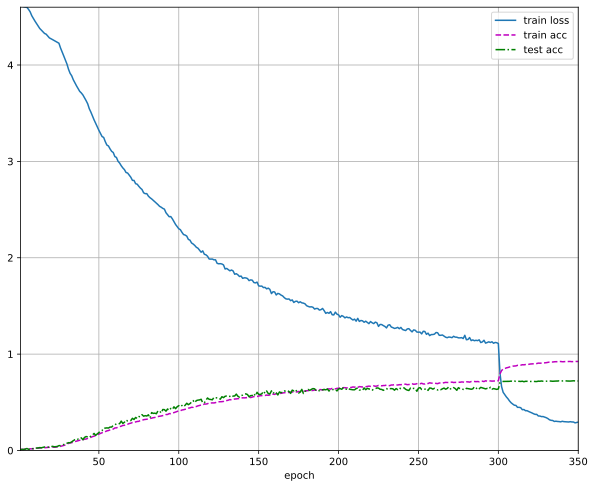

In [ ]:
train_model_on_device(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler, device)

To compare this training to the curves seen in the CIFAR-10 challenge (see below), it is clear that the model starts over fitting at around 200 epochs and significantly overfits when the learning rate is dropped. 

Improvements in training this model would include:
- more extreme transformations - likely to prevent overfitting for a longer training time. 
- Experiments with the learning rates, momentum, and weight decay
- modifications to the k_number convolutional block and channels output for each block
- additional layers to the classifer MLP.
- the modification of ReLU layers to pReLU (parameterised ReLUs)

epoch:  349
final train_acc:  0.98244
final test_acc:  0.9499
final loss:  0.05760353794515133


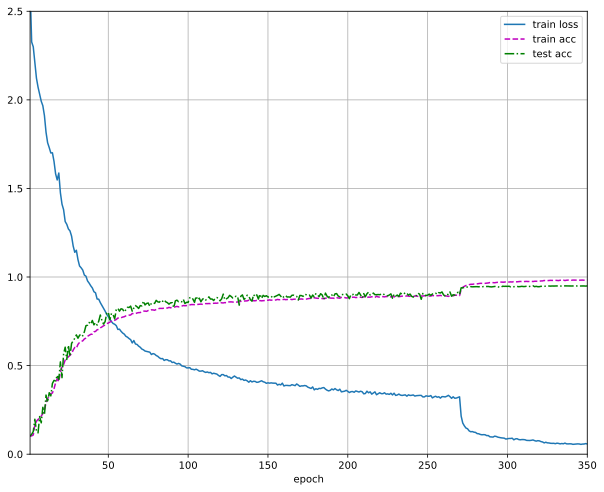

In [ ]:
train_model_on_device(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler, device)

## Section 5: Final Model accuracy on CIFAR-100 validation set

I now reload the CIFAR evaluation set in full and apply only the normalisation values taken from D2L.ai 

**The model has a final accuracy of 72.11%**


In [ ]:
def get_dataloader_workers(): 
    """Use 4 processes to read the data."""
    return 4


def load_eval_cifar_100(batch_size, resize=None):  
    """Download the CIFAR_10 dataset and then load it into memory.
    normalisation values taken from https://d2l.ai/chapter_computer-vision/kaggle-cifar10.html
    """
    #normalisation only
    trans = [transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)) ]
    
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    torchvision.datasets.CIFAR10
    cifar_train = torchvision.datasets.CIFAR100(root="../data", train=True, transform=trans, download=True)
    cifar_test = torchvision.datasets.CIFAR100(root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(cifar_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(cifar_test, batch_size, shuffle=False,num_workers=get_dataloader_workers()))

In [ ]:
batch_size = 300
resize = 56

_, eval_iter = load_eval_cifar_100(batch_size, resize=resize)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
net = net.eval()
evalulation = mu.evaluate_accuracy_gpu(net, eval_iter, device)
print(evalulation)

0.7211


## Appendix: Saved the model, and allow the model to be evaluated independently

Due to the time taken to train, I have created a copy of the model for independent evaluation. 

This is the code to save the model

In [ ]:
torch.save(net.state_dict(), "Lotus_model_cifar100.pkl")


Load the evaluation set

In [ ]:
def get_dataloader_workers(): 
    """Use 4 processes to read the data."""
    return 4


def load_eval_cifar_100(batch_size, resize=None):  
    """Download the CIFAR_100 dataset and then load it into memory.
    normalisation values taken from https://d2l.ai/chapter_computer-vision/kaggle-cifar10.html
    """
    #the most basic transformations
    trans = [transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)) ]
   
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    torchvision.datasets.CIFAR10
    cifar_train = torchvision.datasets.CIFAR100(root="../data", train=True, transform=trans, download=True)
    cifar_test = torchvision.datasets.CIFAR100(root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(cifar_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(cifar_test, batch_size, shuffle=False,num_workers=get_dataloader_workers()))

In [ ]:
batch_size = 300
resize = 56
_, eval_iter = load_eval_cifar_100(batch_size, resize=resize)

Files already downloaded and verified
Files already downloaded and verified


Create an instance of the model and upload the trained model state dictionary. 

You will need to upload the 'Lotus_model_LongRun.pkl' file to the local drive (This file is 1.5GB in size and is avaliable on request)

In [ ]:
conv_arch = ((5, 96), (5, 256), (5, 512),(5, 1024) )
batch_size = 300

model = Lotus_Model(conv_arch, batch_size)
model.load_state_dict(torch.load('Lotus_model_cifar100.pkl'))
model.to(device)
model.eval()
evalulation = mu.evaluate_accuracy_gpu(model, eval_iter, device)
print(evalulation)

0.7211


#Concluding notes

The CIFAR-100 image set is a much harder problem to solve when compared to the CIFAR-10 challenge. 

The probability of a correct prediction before training is just 1% for CIFAR-100, compared to a 10% likelyhood with CIFAR-10. 

This means a model making predictons for CIFAR-10 only needs to improve by 1000% from this baseline to achieve 100% accuracy. We saw in the original CIFAR-10 training, that the Lotus model achieved 95.15% meaning it improved its accuracy by 9517% from the baseline. 

CIFAR-100 truely tests the ability of any model to learn. To reach 100% accuracy from the baseline likelyhood of 1%, a 10,000% improvement needs to be achieved. 

The lotus model has improved 7,211% from the baseline likelyhood, and yet this is only an accuracy of 72.11% 

Based on the learning curves for test and training, it would seem possible to retrain the model with even greater image augmentation strategies. However this notebook was run to test the generalisability of the base architecture on a different but similiar problem. 

## How good are the results?

According to papers with code, https://paperswithcode.com/sota/image-classification-on-cifar-100

My model would rank 152 in its list, achieving parity with state-of-the-art in 2015. 

There does seem to be a realistic upper limit of 94.59% for the CIFAR-100 set. Based on two papers the CIFAR-100 set has a 5.41% error rate in its training set https://arxiv.org/abs/2103.14749 and around 10% of the test set contain images found in the training set https://arxiv.org/abs/1902.00423 .

I was not able to find the human error rate, but I would expect this to be around 90% based on the CIFAR-10 human error rate of 6% and the 5.4% incorrect labels in the training set. 

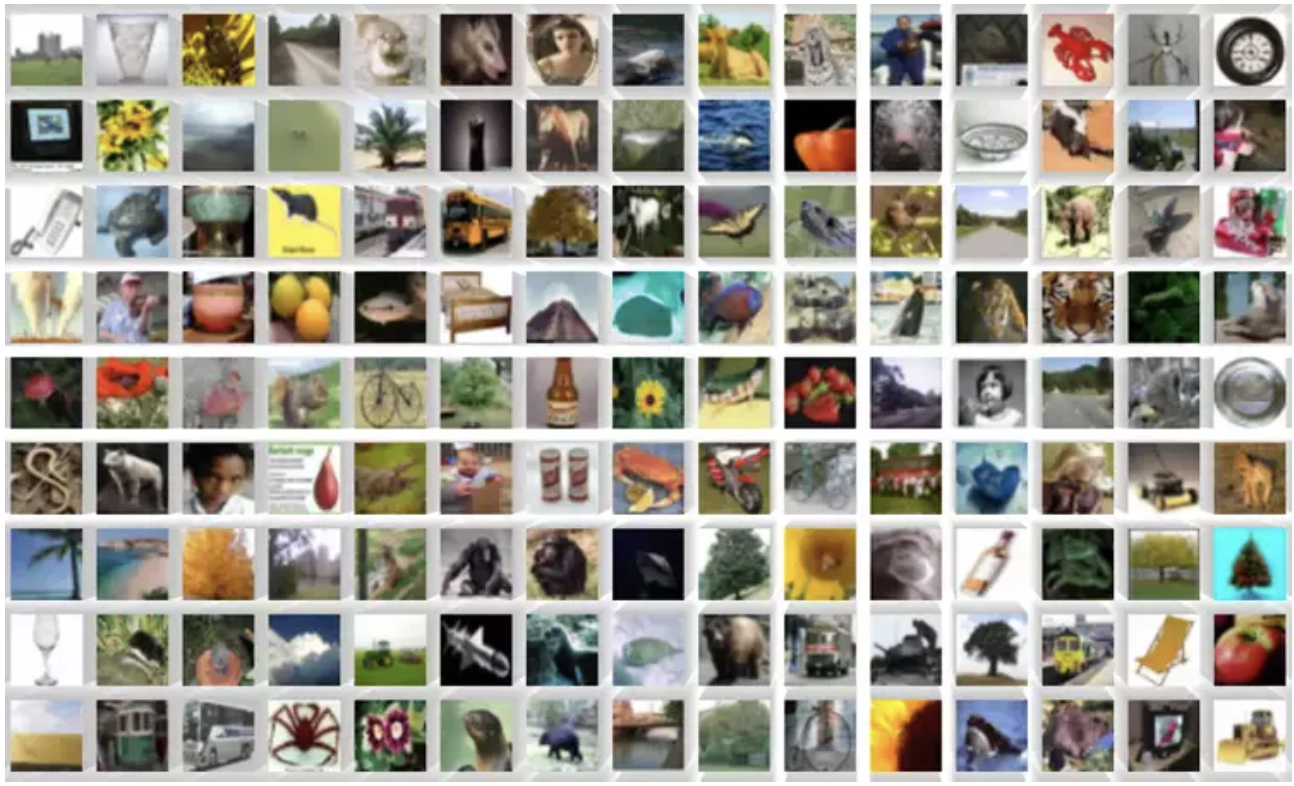